In [ ]:
# Cell 1 — Imports & Model Loading
import os
from config import IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNEL, OUTPUT_CHANNEL, HIDDEN_SIZE, NUM_FIDUCIAL, CHARACTERS  
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataset import LmdbDataset, AlignCollate
from utils import AttnLabelConverter, Averager
from model import CRNN
import pandas as pd
import matplotlib.pyplot as plt

# device & paths
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEST_LMDB    = "lmdb_data/test"
MODEL_PATH   = "trained_model/best_attention_crnn_no_!_5992.pth"  # wherever you saved it

# build converter & model
converter   = AttnLabelConverter(CHARACTERS)
num_classes = len(converter.character)
model = CRNN(
    IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNEL,
    OUTPUT_CHANNEL, HIDDEN_SIZE, num_classes,
    True, NUM_FIDUCIAL
).to(device)

model.Transformation = nn.Identity() # <-- no transformation

# load weights & set eval
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# loss
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)

In [3]:
# Cell 2 — Test‐loader & evaluation function
# prepare test DataLoader
collate_fn   = AlignCollate(imgH=IMG_HEIGHT, imgW=IMG_WIDTH, keep_ratio_with_pad=False)
test_ds      = LmdbDataset(TEST_LMDB)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False,
                          num_workers=0, collate_fn=collate_fn, pin_memory=True)

def evaluate(model, loader, max_len=25):
    model.eval()
    avg_loss = Averager()
    total_samples = correct_samples = 0
    total_chars   = correct_chars   = 0
    all_confs = []

    with torch.no_grad():
        for images, texts in loader:
            images = images.to(device)
            # encode → [B, L+1], lengths
            text, length = converter.encode(texts, batch_max_length=max_len)
            inp    = text[:, :-1].to(device)
            target = text[:,  1:].to(device)

            # forward + loss
            preds = model(images, text=inp, is_train=False, batch_max_length=max_len)  # [B,S,C]
            B, S, C = preds.size()
            loss = criterion(preds.reshape(B*S, C), target.reshape(B*S))
            avg_loss.add(loss)

            # get per-token probs, predicted indices, strings
            probs        = preds.softmax(2)            # [B,S,C]
            max_vals, max_inds = probs.max(2)          # [B,S]
            pred_strs    = converter.decode(max_inds, length)
            pred_strs    = [s.split('[s]')[0] for s in pred_strs]

            # accumulate sample-level and char-level stats
            for gt, pr, conf_seq in zip(texts, pred_strs, max_vals):
                total_samples += 1
                if pr == gt:
                    correct_samples += 1

                # char-level: compare up to len(gt), missing preds count as wrong
                for i, ch in enumerate(gt):
                    if i < len(pr) and pr[i] == ch:
                        correct_chars += 1
                total_chars += len(gt)

                all_confs.append(conf_seq.mean().item())

    sample_acc = correct_samples / total_samples * 100
    char_acc   = correct_chars   / total_chars   * 100
    return avg_loss.val(), sample_acc, char_acc, all_confs

# run it
test_loss, sample_acc, char_acc, confidences = evaluate(model, test_loader, max_len=25)
print(f"Test loss: {test_loss:.4f}  "
      f"Sample-level acc: {sample_acc:.2f}%  "
      f"Char-level   acc: {char_acc:.2f}%")


Loaded 127 valid samples from lmdb_data/test
Test loss: 1.0700  Sample-level acc: 49.61%  Char-level   acc: 82.36%


,Metric,Value
0,Test Loss,1.070014
1,Test Accuracy,49.606299


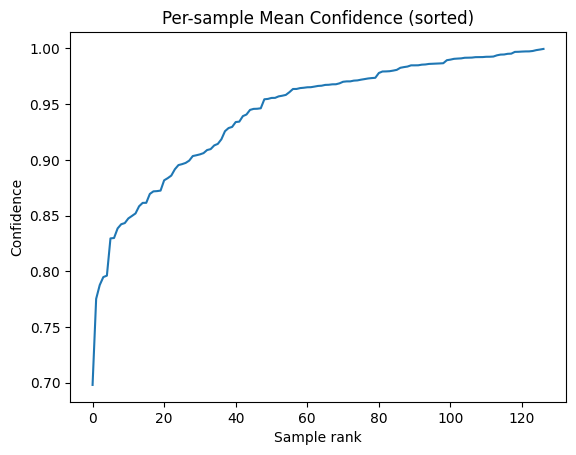

In [4]:
# Cell 3 — Summary table & line‐plot of confidences over samples
# 1) summary table
test_loss_val = test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss

df = pd.DataFrame({
    'Metric': ['Test Loss', 'Test Accuracy'],
    'Value' : [test_loss_val, sample_acc]
})
display(df)

# 2) plot confidences (sorted) to see distribution
sorted_confs = sorted(confidences)
plt.figure()
plt.plot(sorted_confs)
plt.title("Per-sample Mean Confidence (sorted)")
plt.xlabel("Sample rank")
plt.ylabel("Confidence")
plt.show()


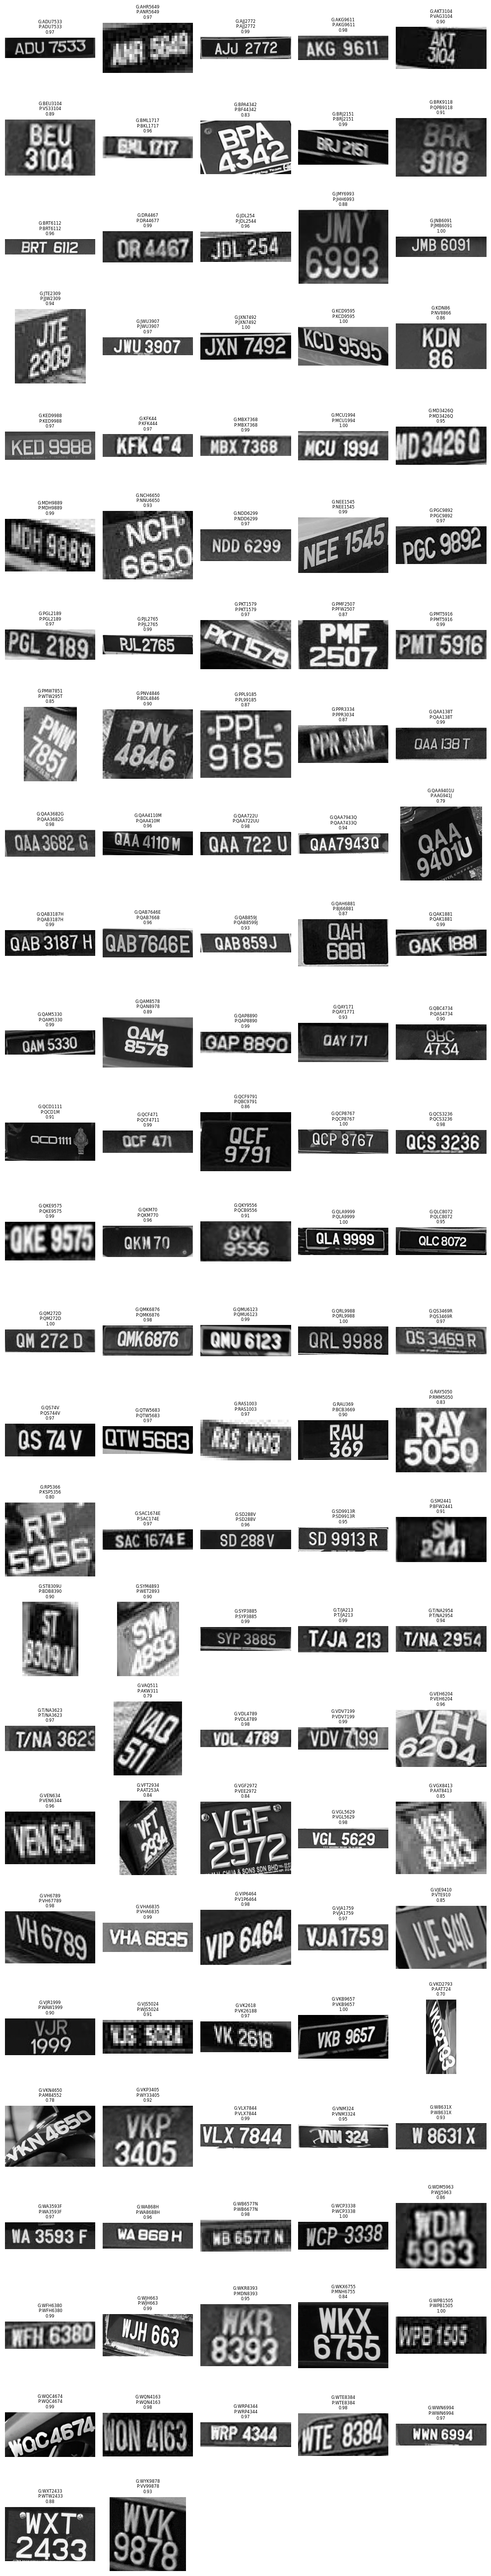

In [5]:
# Cell 4 — Visualize *all* test examples
import math
import matplotlib.pyplot as plt

n = len(test_ds)
# let's do up to, say, 5 columns per row
cols = 5
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for ax in axes[n:]:
    ax.axis('off')  # turn off any extra axes

for idx in range(n):
    img, gt = test_ds[idx]
    ax = axes[idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    # prepare single‐image batch
    image_batch, _ = collate_fn([(img, gt)])
    image_batch = image_batch.to(device)

    # forward
    text, length = converter.encode([gt], batch_max_length=25)
    inp = text[:, :-1].to(device)
    preds = model(image_batch, text=inp, is_train=False, batch_max_length=25)

    # decode + conf
    probs       = preds.softmax(2)
    max_vals, max_inds = probs.max(2)
    pr = converter.decode(max_inds, length)[0].split('[s]')[0]
    conf = max_vals.mean().item()

    ax.set_title(f"G:{gt}\nP:{pr}\n{conf:.2f}", fontsize=6)

plt.tight_layout()
plt.show()


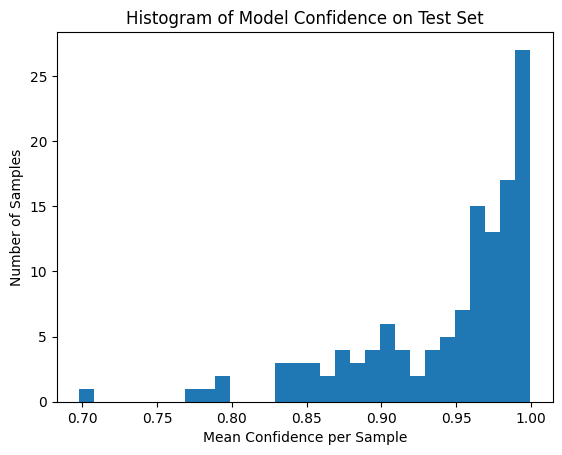

In [6]:
# Cell 5 — Histogram of confidences
plt.figure()
plt.hist(confidences, bins=30)
plt.title("Histogram of Model Confidence on Test Set")
plt.xlabel("Mean Confidence per Sample")
plt.ylabel("Number of Samples")
plt.show()
